In [39]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import libpysal.weights as sw #spat

In [2]:
df = gpd.read_file("data/shp/MD_df.shp")
df = df.dropna()
df = df[(df["PopDen"] > 0.0001) & (df["TotalPop"] > 1000)]

In [3]:
len(df)

1128

In [4]:
cols = ['White', 'Black', 'Native', 'Asian', 'Other',
       'PopDen', 'Age0-19', 'Age20-39', 'Age40-59', 'Age60-79', 'Age80+',
       'Bachelor+', 'BelowPov', 'MHI', 'UnempRt', 'Uninsured']

# Hist check

In [51]:
y1_95p = np.percentile(df["case0630"], 95)
y2_95p = np.percentile(df["case0831"], 95)

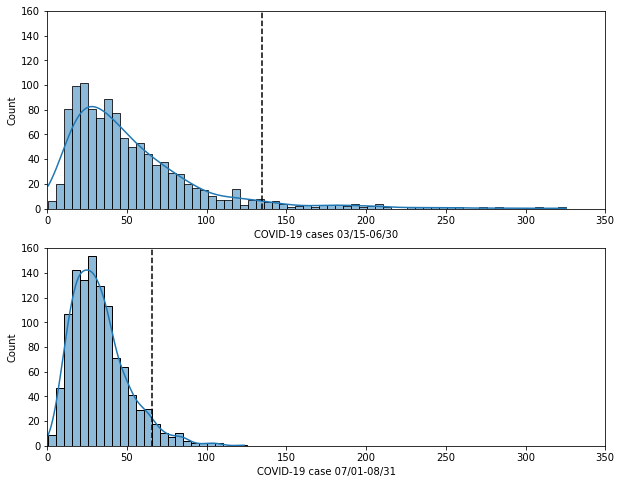

In [52]:
BINWIDTH = 5

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(data=df, x="case0630",binwidth=BINWIDTH, kde=True, ax=ax[0])
ax[0].axvline(y1_95p, color="k", linestyle="--")
ax[0].set_xlabel("COVID-19 cases 03/15-06/30")
ax[0].set_xlim(0, 350)
ax[0].set_ylim(0, 160)


sns.histplot(data=df, x="case0831", binwidth=BINWIDTH, kde=True, ax=ax[1])
ax[1].axvline(y2_95p, color="k", linestyle="--")
ax[1].set_xlabel("COVID-19 case 07/01-08/31")
ax[1].set_xlim(0, 350)
ax[1].set_ylim(0, 160)

plt.show()

fig.savefig("figs/COVID-19/cases_hist.png", dpi=220)

In [53]:
df1 = df[df["case0630"] < y1_95p].copy()
df2 = df[df["case0831"] < y2_95p].copy()

print(len(df1))
print(len(df2))

1071
1071


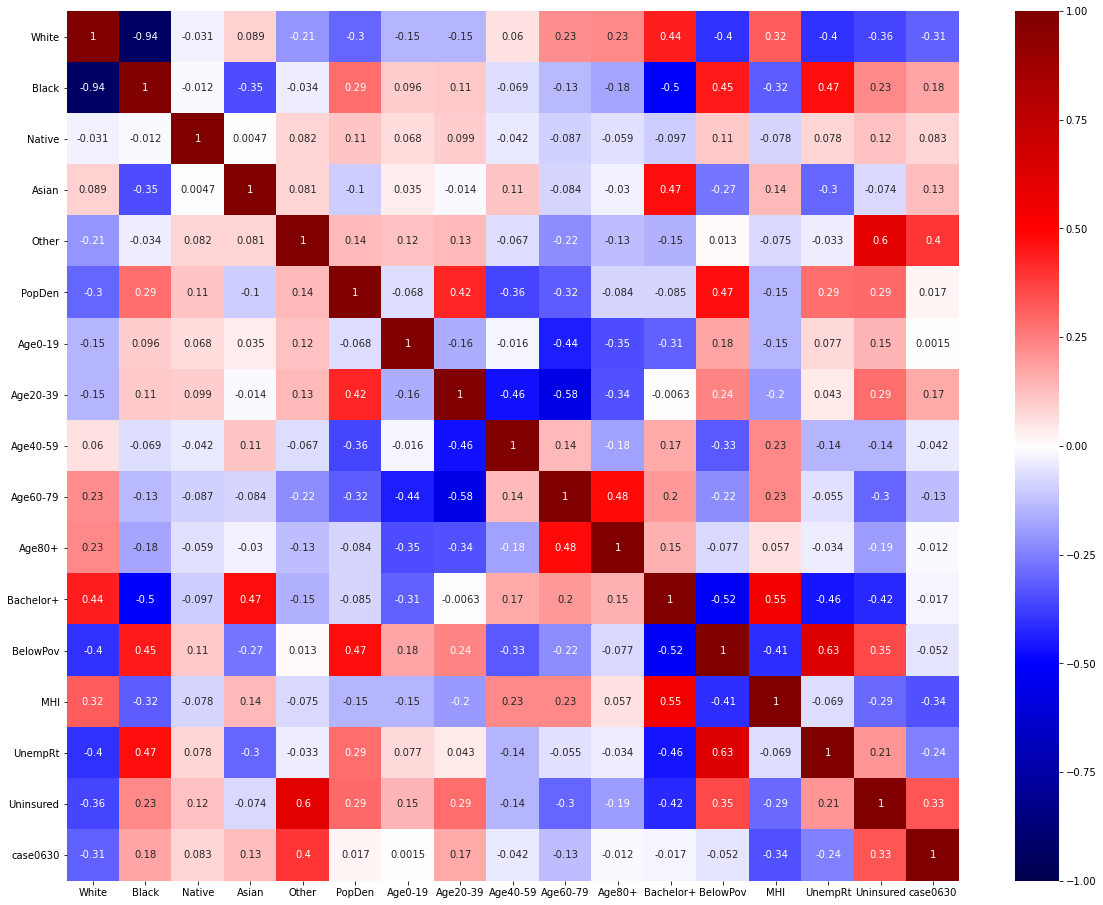

In [64]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(df1[cols + ["case0630"]].corr(), vmin=-1, vmax=1,cmap="seismic", annot=True, ax=ax)

fig.savefig("figs/random_forest/HeatMap_0630.png", dpi=220)

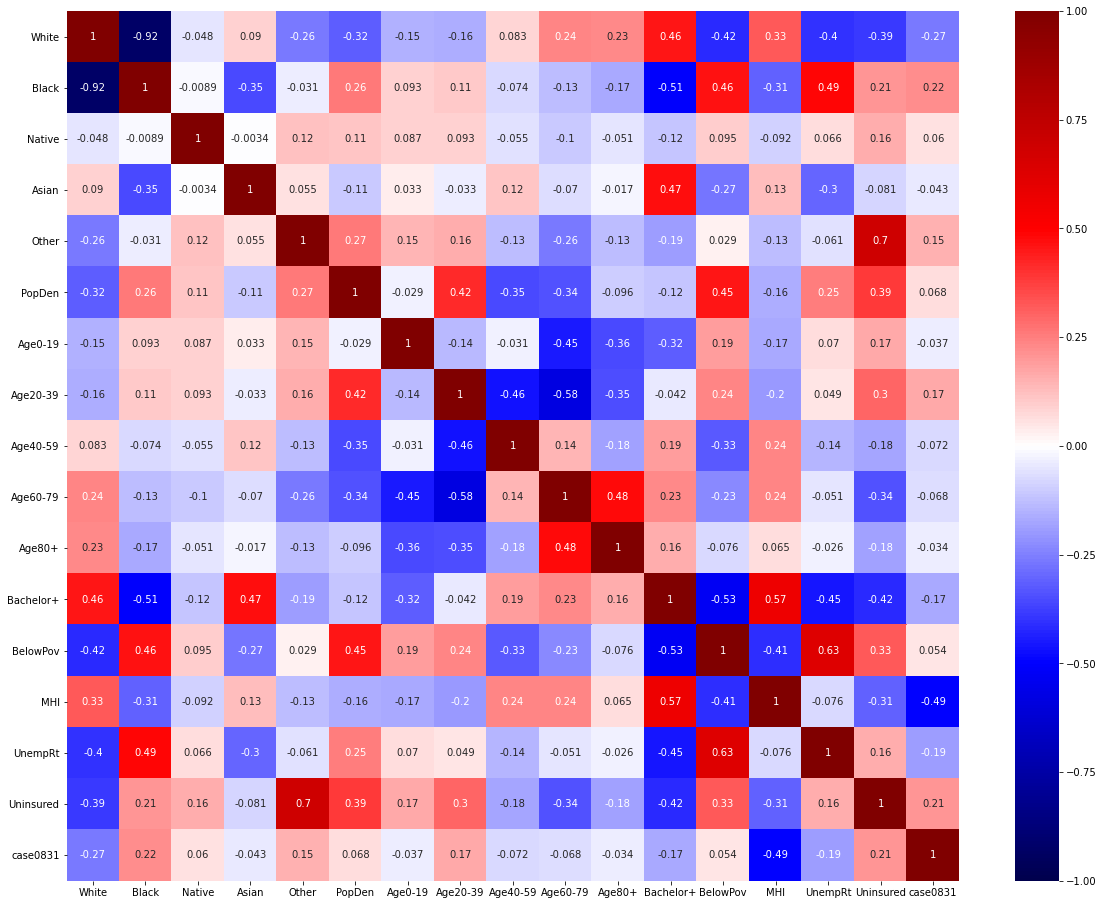

In [65]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(df2[cols + ["case0831"]].corr(), vmin=-1, vmax=1,cmap="seismic", annot=True, ax=ax)

fig.savefig("figs/random_forest/HeatMap_0831.png", dpi=220)

# OLS

In [7]:
from pysal.model import spreg #spatial regression module

In [40]:
X1 = df1[cols].values
y1 = df1["case0630"].values.reshape((-1, 1))
w1 = sw.Queen.from_dataframe(df1)

X2 = df2[cols].values
y2 = df2["case0831"].values.reshape((-1, 1))
w2 = sw.Queen.from_dataframe(df2)

X1 = (X1 - X1.mean(axis=0)) / X1.std(axis=0)
X2 = (X2 - X2.mean(axis=0)) / X2.std(axis=0)
y1 = (y1 - y1.mean(axis=0)) / y1.std(axis=0)
y2 = (y2 - y2.mean(axis=0)) / y2.std(axis=0)

In [42]:
ols = spreg.OLS(y1, X1, w1, spat_diag=True, name_y="Cases 06/30", name_x=cols)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : Cases 06/30                Number of Observations:        1071
Mean dependent var  :     -0.0000                Number of Variables   :          17
S.D. dependent var  :      1.0005                Degrees of Freedom    :        1054
R-squared           :      0.4715
Adjusted R-squared  :      0.4635
Sum squared residual:     565.977                F-statistic           :     58.7804
Sigma-square        :       0.537                Prob(F-statistic)     :   1.32e-133
S.E. of regression  :       0.733                Log likelihood        :   -1178.145
Sigma-square ML     :       0.528                Akaike info criterion :    2390.289
S.E of regression ML:      0.7270                Schwarz criterion     :    2474.887

-----------------------------------------------------------------------------

In [43]:
ols = spreg.OLS(y2, X2, w2, spat_diag=True, name_y="Cases 08/31", name_x=cols)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : Cases 08/31                Number of Observations:        1071
Mean dependent var  :      0.0000                Number of Variables   :          17
S.D. dependent var  :      1.0005                Degrees of Freedom    :        1054
R-squared           :      0.3840
Adjusted R-squared  :      0.3746
Sum squared residual:     659.757                F-statistic           :     41.0615
Sigma-square        :       0.626                Prob(F-statistic)     :   3.883e-99
S.E. of regression  :       0.791                Log likelihood        :   -1260.246
Sigma-square ML     :       0.616                Akaike info criterion :    2554.493
S.E of regression ML:      0.7849                Schwarz criterion     :    2639.091

-----------------------------------------------------------------------------

# RF

In [12]:
parameters = {
    "n_estimators": [10, 100, 200, 300, 500, 800],
    "max_features": ["auto", "sqrt"],
    "max_depth": [5, 10, 20, 40, 60],
    "min_samples_leaf": [1, 2, 4, 8]
}

### 06/30

In [44]:
X1 = df1[cols]
y1 = df1["case0630"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=1000)

In [45]:
regr = RandomForestRegressor(random_state=1000)

gridforest1 = GridSearchCV(regr, parameters, cv=5, n_jobs=-1, verbose=1)
gridforest1.fit(X1_train, y1_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  4.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1000),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'n_estimators': [10, 100, 200, 300, 500, 800]},
             verbose=1)

In [46]:
gridforest1.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'n_estimators': 100}

In [47]:
print(gridforest1.best_estimator_)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=4,
                      random_state=1000)


In [48]:
# Get the best model
model1 = gridforest1.best_estimator_
y1_pred = model1.predict(X1_test)

print("R-squared: %.4f, %.4f" % (model1.score(X1_train, y1_train), model1.score(X1_test, y1_test)))

rmse_train = np.sqrt(mean_squared_error(y1_train, model1.predict(X1_train)))
rmse_test = np.sqrt(mean_squared_error(y1_test, model1.predict(X1_test)))
print("RMSE: %.2f, %.2f" % (rmse_train, rmse_test))

mae_train = mean_absolute_error(y1_train, model1.predict(X1_train))
mae_test = mean_absolute_error(y1_test, model1.predict(X1_test))
print("MAE: %.2f, %.2f" % (mae_train, mae_test))

R-squared: 0.7703, 0.4586
RMSE: 13.12, 21.71
MAE: 9.65, 15.81


vis check

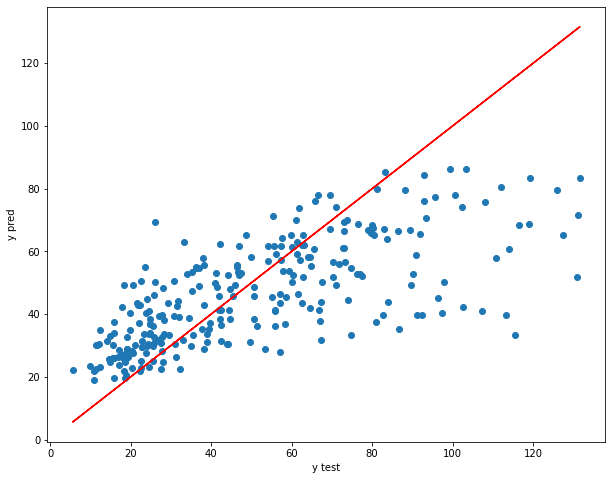

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(y1_test, y1_pred)
plt.plot(y1_test, y1_test, color="red")
plt.xlabel("y test")
plt.ylabel("y pred")

plt.show()

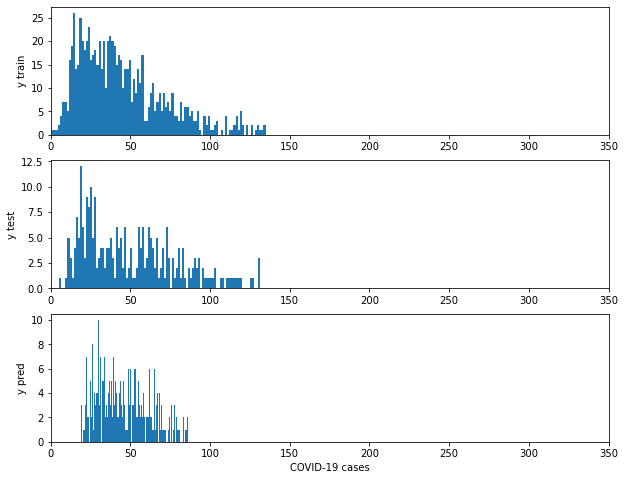

In [55]:
BINS = 100

fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].hist(y1_train, bins=BINS)
ax[0].set_xlim(0, 350)
# ax[0].set_ylim(0, 50)
ax[0].set_ylabel("y train")

ax[1].hist(y1_test, bins=BINS)
ax[1].set_xlim(0, 350)
# ax[1].set_ylim(0, 50)
ax[1].set_ylabel("y test")

ax[2].hist(y1_pred, bins=BINS)
ax[2].set_xlim(0, 350)
# ax[2].set_ylim(0, 50)
ax[2].set_ylabel("y pred")

plt.xlabel("COVID-19 cases")
# plt.ylabel("Histogram")

plt.show()

In [56]:
# Feature Importance
feature_imp1 = pd.Series(model1.feature_importances_, index=X1.columns).sort_values(ascending=False)
feature_imp1

White        0.142059
UnempRt      0.127590
Other        0.123770
MHI          0.110891
Black        0.073629
Uninsured    0.068290
Bachelor+    0.050823
Asian        0.047234
BelowPov     0.041301
Age20-39     0.039785
PopDen       0.037118
Age80+       0.035943
Age40-59     0.031935
Age0-19      0.029596
Age60-79     0.025577
Native       0.014457
dtype: float64

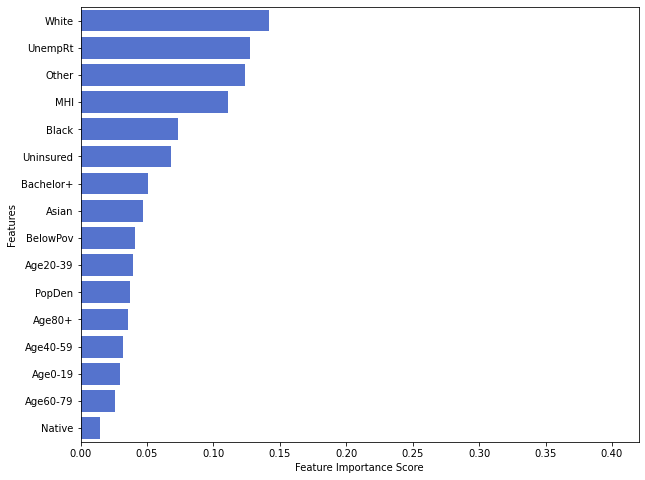

In [57]:
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_imp1, y=feature_imp1.index, color="royalblue", ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.xlim(0, 0.42)
plt.show()

fig.savefig("figs/random_forest/FeatureImp_0630.png", dpi=220)

### 08/31

In [58]:
X2 = df2[cols]
y2 = df2["case0831"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1000)

In [59]:
regr2 = RandomForestRegressor(random_state=1000)

gridforest2 = GridSearchCV(regr2, parameters, cv=5, n_jobs=-1, verbose=1)
gridforest2.fit(X2_train, y2_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  4.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1000),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'n_estimators': [10, 100, 200, 300, 500, 800]},
             verbose=1)

In [60]:
gridforest2.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'n_estimators': 800}

In [61]:
# Get the best model
model2 = gridforest2.best_estimator_
y2_pred = model2.predict(X2_test)

print("R-squared: %.4f, %.4f" % (model2.score(X2_train, y2_train), model2.score(X2_test, y2_test)))

rmse_train = np.sqrt(mean_squared_error(y2_train, model2.predict(X2_train)))
rmse_test = np.sqrt(mean_squared_error(y2_test, model2.predict(X2_test)))
print("RMSE: %.2f, %.2f" % (rmse_train, rmse_test))

mae_train = mean_absolute_error(y2_train, model2.predict(X2_train))
mae_test = mean_absolute_error(y2_test, model2.predict(X2_test))
print("MAE: %.2f, %.2f" % (mae_train, mae_test))

R-squared: 0.8206, 0.3893
RMSE: 6.00, 10.17
MAE: 4.48, 8.01


In [62]:
# Feature Importance
feature_imp2 = pd.Series(model2.feature_importances_, index=X2.columns).sort_values(ascending=False)
feature_imp2

MHI          0.361217
UnempRt      0.131368
Black        0.070938
White        0.064878
Age0-19      0.058943
PopDen       0.051257
Uninsured    0.031583
Age40-59     0.030475
Bachelor+    0.029994
Age80+       0.029466
Age60-79     0.028715
BelowPov     0.026838
Age20-39     0.025723
Asian        0.025299
Other        0.024145
Native       0.009161
dtype: float64

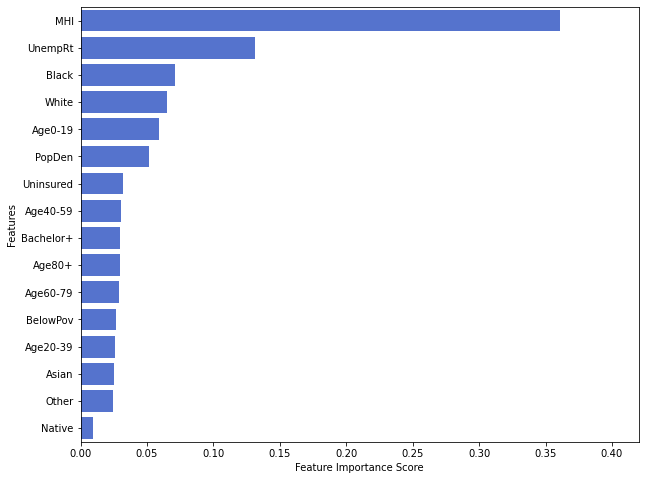

In [63]:
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_imp2, y=feature_imp2.index, color="royalblue", ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.xlim(0, 0.42)
# plt.title("Visualizing Important Features\nPalm Beach County")
plt.show()

fig.savefig("figs/random_forest/FeatureImp_0831.png", dpi=220)